# **ĐỒ ÁN 2**


---

# **NGHIÊN CỨU CÁC KĨ THUẬT PHÂN ĐOẠN ẢNH VÀ TRÍCH SUẤT ĐẶC TRƯNG**


**Giảng viên hướng dẫn: Ths Hà Lê Ngọc Dung**


**Sinh viên thực hiện:**
1.   **Từ Thái Bảo         MSSV: 1900222**

2.   **Lâm Thiện Nhân      MSSV: 1900558**

3.   **Nguyễn Duy Khánh    MSSV: 1900540**


---

#**Cài đặc các thư viện cần thiết**


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model

#**Tải dữ liệu**
Hệ thống nhận dạng bệnh viêm phổi này sử dụng bộ dữ liệu gồm những hình ảnh x-quang về phổi được lấy trực tiếp từ Kaggle.  https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Tập dữ liệu được tổ chức thành 3 thư mục (train, test, val) và chứa các thư mục con cho từng loại hình ảnh (Pneumonia / Normal).
Có 5.863 hình ảnh X-Ray (JPEG) và 2 loại (Viêm phổi / Bình thường).

Hình ảnh X-quang ngực (trước-sau) được chọn từ nhóm hồi cứu bệnh nhi từ một đến năm tuổi từ Trung tâm Y tế Phụ nữ và Trẻ em Quảng Châu, Quảng Châu. Tất cả hình ảnh X-quang ngực được thực hiện như một phần của chăm sóc lâm sàng định kỳ cho bệnh nhân.

Đối với việc phân tích các hình ảnh X-quang phổi, tất cả các hình chụp X quang phổi ban đầu đều được sàng lọc để kiểm soát chất lượng bằng cách loại bỏ tất cả các hình quét chất lượng thấp hoặc không thể đọc được. Các chẩn đoán hình ảnh sau đó được phân loại bởi hai bác sĩ chuyên môn trước khi được xóa để đào tạo hệ thống AI. Để giải thích cho bất kỳ lỗi chấm điểm nào, bộ đánh giá cũng đã được kiểm tra bởi một chuyên gia thứ ba.

In [ ]:
! pip install -q kaggle

In [ ]:
# Chọn file kaggle.json
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tthibo","key":"dd0f7b36e309dbd23e4cf4fc2e1a1c64"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23           9199        282  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           4831        156  0.9705882        
mohamedharris/supermart-grocery-sales-retail-analytics-dataset  Supermart Grocery Sales - Retail Analytics Dataset  191KB  2022-06-12 16:14:44            651         42  0.88235295       

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:10<00:00, 149MB/s]
100% 2.29G/2.29G [00:10<00:00, 238MB/s]


In [ ]:
#Giải nén dử liệu
!unzip -u "/content/chest-xray-pneumonia.zip" -d "/content/"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0445-0001.j

Gán nhãn cho từng bộ dữ liệu

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/chest_xray/train')
test = get_training_data('/content/chest_xray/test')
val = get_training_data('/content/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


In [ ]:
print("The number of Train data: ",len(train))
print("The number of Test data: ",len(test))
print("The number of Val data: ",len(val))
print("The number of DATASET", len(train)+len(test)+len(val))

The number of Train data:  5216
The number of Test data:  624
The number of Val data:  16
The number of DATASET 5856


# **Tiền xử lý và trực quan hoá dữ liệu**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


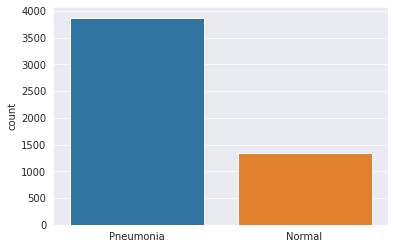

In [ ]:
#Xem biểu đổ thống kê số lượng của tập dữ liệu train
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Dữ liệu của bộ dữ liệu huấn luyện không cân bằng. Có thể khắc phục nó bằng cách sử dụng các kĩ thuật tăng cường dữ liệu.

Xem trước hình ảnh của cả hai lớp.

Text(0.5, 1.0, 'NORMAL')

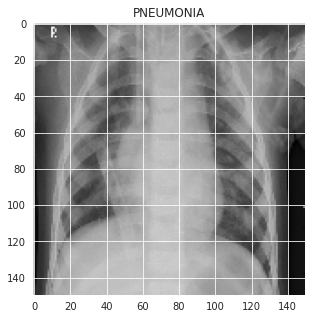

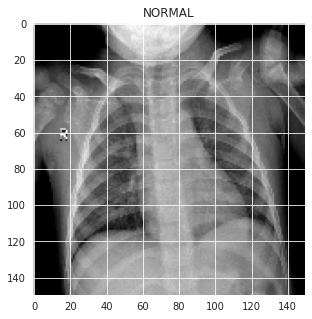

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

Chúng tôi thực hiện chuẩn hóa dử liệu thang độ xám để giảm ảnh hưởng của sự khác biệt về độ chiếu sáng. Hơn nữa, CNN xử lý dữ liệu trên [0..1] nhanh hơn so với trên [0..255].

In [ ]:
# Chuẩn hoá dử liệu
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# Thay đổi kích thước dữ liệu
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)



# **Tăng cường dữ liệu**
Để cân bằng lại dữ liệu, ta sẽ dùng những kĩ thuật tăng cường dữ liệu. Ý tưởng là thay đổi tập dữ liệu train bằng các biến đổi nhỏ(từng chút) để tái tạo các biến thể. Tăng cường dữ liệu bằng cách thay đổi biểu diễn mảng nhưng vẫn giữ nguyên nhãn.

Một số phép tăng cường dữ liệu được sử dụng là thay đổi: thang độ xám, lật ngang, lật dọc, màu sắc, độ nhiễu, phép quay... Chỉ cần áp dụng một vài phép biến đổi này vào dữ liệu train, chúng ta có thể dễ dàng tăng gấp đôi hoặc gấp ba số lượng dữ liệu huấn luyện và tạo ra một mô hình rất mạnh mẽ.

In [ ]:
# Do bộ dữ liệu mất cân bằng nên ta áp dụng các kĩ thuật tăng cường dữ liệu.

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

datagen.fit(x_train)



Để tăng cường cho bộ dữ liệu, cấu hình như sau:

1. Xoay(rotation) ngẫu nhiên những hình ảnh huấn luyện 30 độ.
2. Thu(zoom) phóng ngẫu nhiên 20% những hình ảnh huấn luyện.
3. Di chuyển ngẫu nhiên hình ảnh theo chiều ngang(horizontally) bằng 10% chiều rộng(width).
4. Dịch chuyển ngẫu nhiên ảnh theo chiều dọc(vertically) bằng 10% chiều cao(height).
5. Lật(flip) ngẫu nhiên hình ảnh theo chiều ngang.

=> Khi mô hình đã sẵn sàng, các dữ liệu này sẽ được đem đi huấn luyện.

#**Cấu hình cho mạng thần kinh tích chập**

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' ,
                 activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' ,
                 activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' ,
                 activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' ,
                 activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' ,
                 activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' ,
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 12 ,
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 24s 67ms/step - loss: 0.4623 - accuracy: 0.8399 - val_loss: 35.0812 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 11s 66ms/step - loss: 0.2719 - accuracy: 0.8957 - val_loss: 59.3053 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.9133
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 11s 66ms/step - loss: 0.2572 - accuracy: 0.9133 - val_loss: 55.4326 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 11s 66ms/step - loss: 0.1587 - accuracy: 0.9482 - val_loss: 24.4977 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9548
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 13ms/step - loss: 0.3003 - accuracy: 0.9119
Loss of the model is -  0.30030596256256104
20/20 [==============================] - 0s 13ms/step - loss: 0.3003 - accuracy: 0.9119
Accuracy of the model is -  91.18589758872986 %


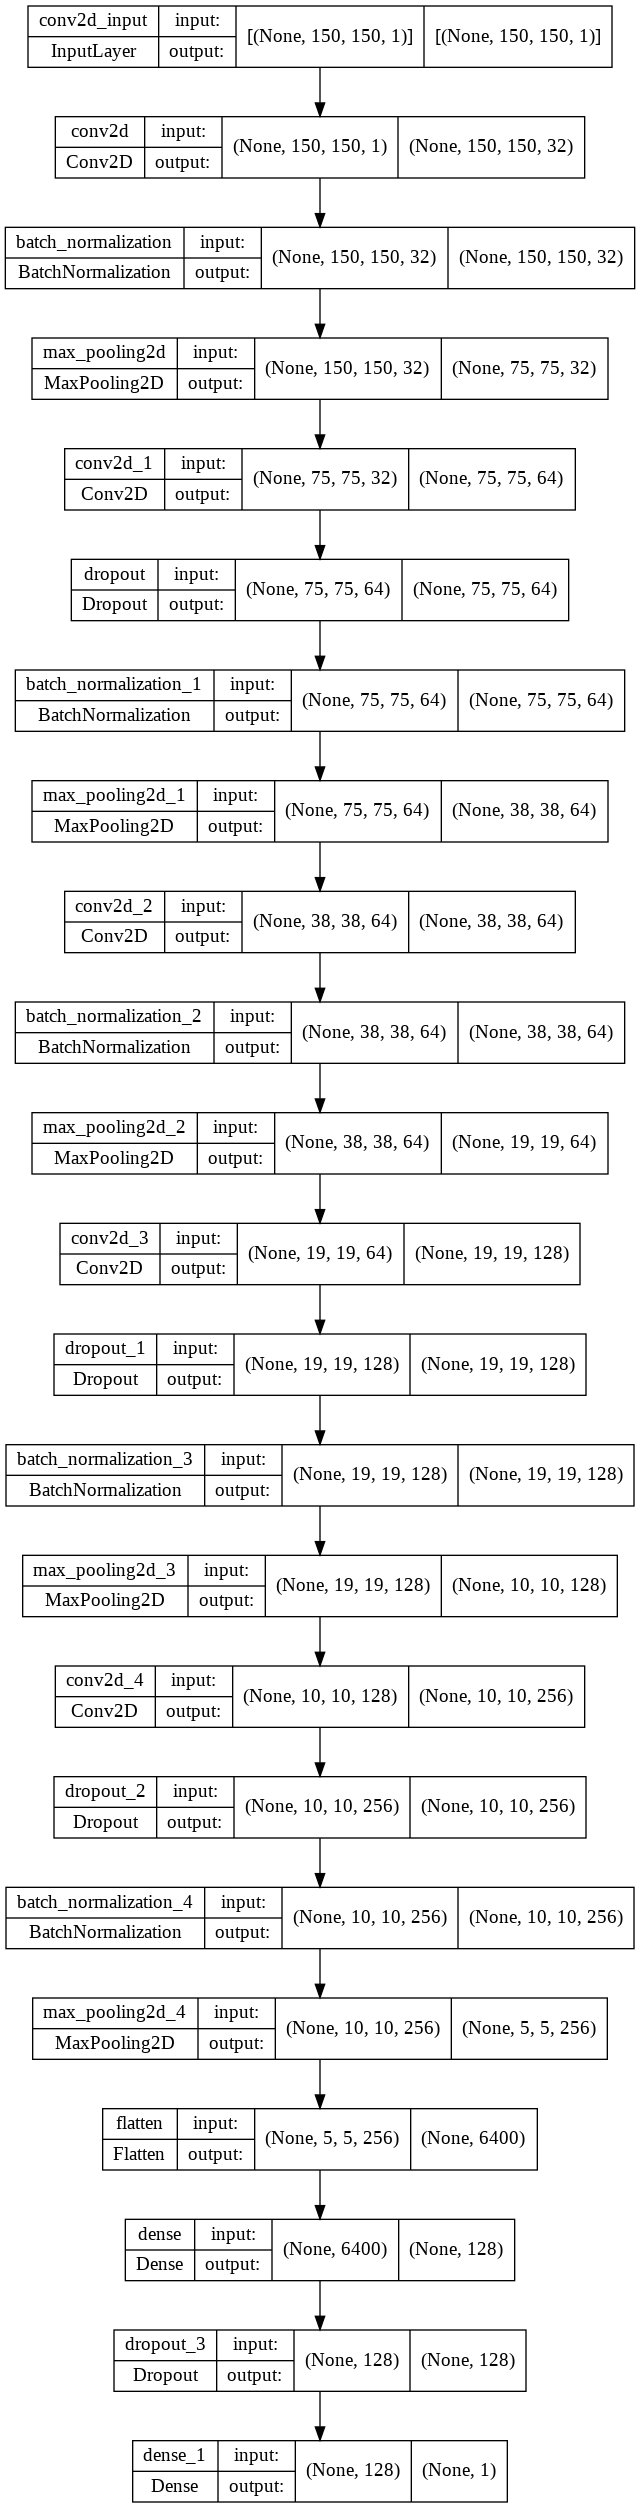

In [ ]:
plot_model(model, to_file='cnn.png', show_shapes=True)

In [ ]:
model.save('model.h5')
#model = load_model('model.h5')

# **Phân tích sau khi đào đạo mô hình**

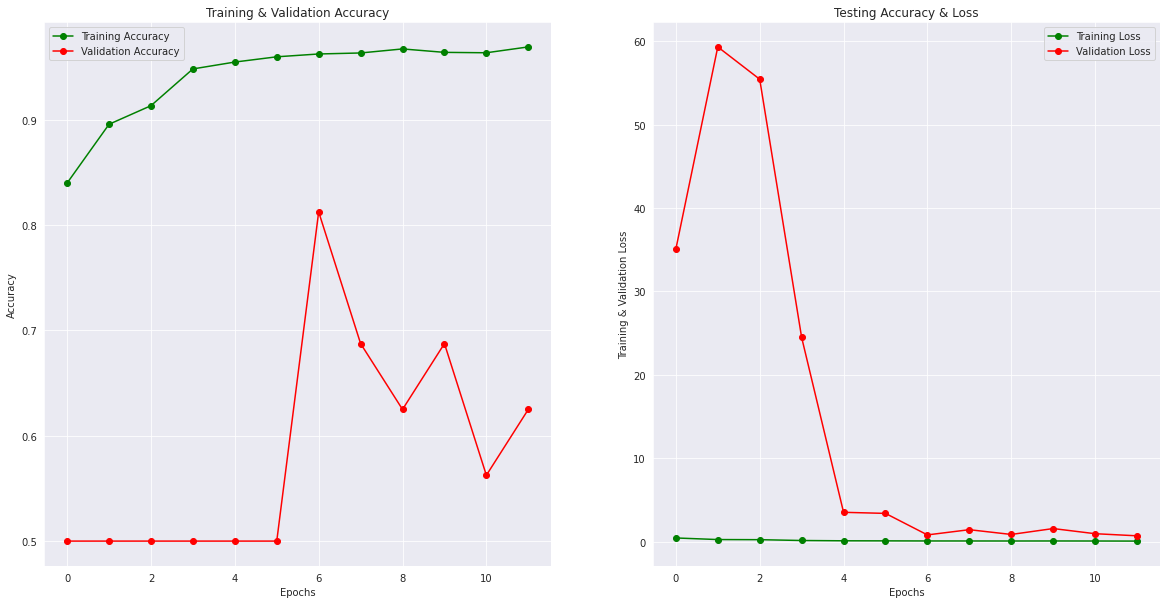

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

#**Dự đoán**
Sử dụng các tri thức đã được train để dự đoán các ảnh trong tập test.

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]

predictions[95:115]
arr_predictions = predictions[95:115]

for i in range(len(arr_predictions)):
  if arr_predictions[i] == 0:
    print("Image-{}: Pneumonia".format(i))
  else:
    print("Image-{}: Normal".format(i))

Image-0: Pneumonia
Image-1: Pneumonia
Image-2: Pneumonia
Image-3: Pneumonia
Image-4: Pneumonia
Image-5: Pneumonia
Image-6: Pneumonia
Image-7: Pneumonia
Image-8: Pneumonia
Image-9: Pneumonia
Image-10: Pneumonia
Image-11: Pneumonia
Image-12: Pneumonia
Image-13: Pneumonia
Image-14: Pneumonia
Image-15: Pneumonia
Image-16: Pneumonia
Image-17: Pneumonia
Image-18: Pneumonia
Image-19: Pneumonia


#**Đánh giá mô hình**

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.93      0.93       390
   Normal (Class 1)       0.88      0.88      0.88       234

           accuracy                           0.91       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.91      0.91      0.91       624



In [ ]:
# Xây đưng ma trận hỗn loạn
cm = confusion_matrix(y_test,predictions)
cm

array([[363,  27],
       [ 28, 206]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

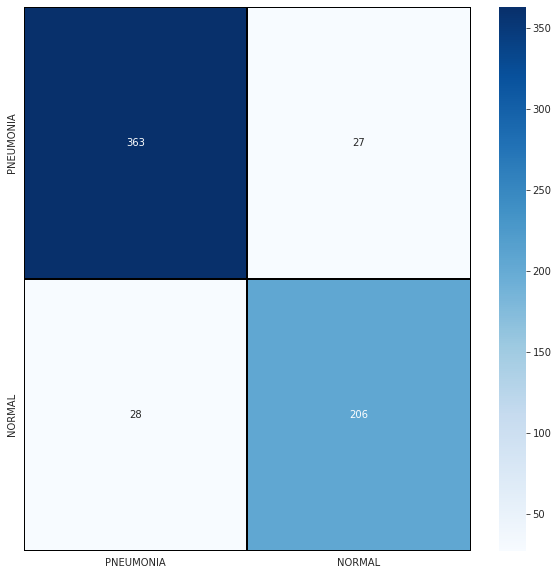

In [ ]:
# Trực quan hoá ma trận hỗn loạn
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

##**Một số hình ảnh được dự đoán chính xác**

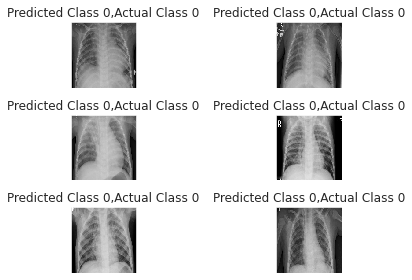

In [ ]:
i = 0
for c in correct[40:46]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

##**Một số hình ảnh được dự đoán không chính xác**

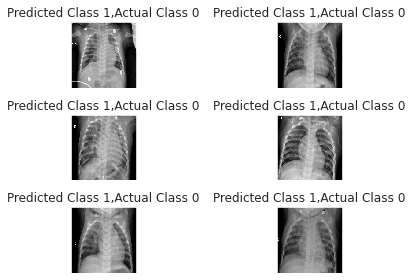

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1